In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
import load_cdf as cdf
import cmath
import scipy.sparse
from scipy.sparse import csr_matrix, diags, linalg
from sympy.solvers import solve
from sympy import Symbol
import cvxpy as cvx

In [ ]:
# `numpy.random` uses its own PRNG.

r = np.round(np.random.rand(1000),1)
plt.hist(x=r,bins=[0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [ ]:
# matrix solver

A = np.matrix([[3/20,-1/10,-1/20],[1/10,-29/200,1/40],[-1/20,-1/40,3/40]])
b = np.matrix([[5],[0],[2]])

A_inv = np.linalg.inv(A)

x = A_inv * b

x

In [ ]:
# plotter

f = 60
w = 2 * np.pi * f
t = np.arange(0,2/f,0.0001)

v = 132.7 * math.sqrt(2) * np.cos(w * t)
i = 13.27 * math.sqrt(2) * np.cos(w * t + np.radians(-30))
p = v * i

In [ ]:
plt.plot(t,v)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (kV)")
plt.title("V(t)")
plt.show()

In [ ]:
plt.plot(t,i)
plt.xlabel("Time (s)")
plt.ylabel("Current (kA)")
plt.title("I(t)")
plt.show()

In [ ]:
plt.plot(t,p)
plt.xlabel("Time (s)")
plt.ylabel("Power (MW)")
plt.title("P(t)")
plt.show()

In [ ]:
# compute the real power at each bus and the power lost through the distribution line

def ComputeTwoBusRealPower(Z, V1, theta1, V2, theta2):
    V1 = complex(V1 * np.cos(np.radians(theta1)), V1 * np.sin(np.radians(theta1)))
    V2 = complex(V2 * np.cos(np.radians(theta2)), V2 * np.sin(np.radians(theta2)))
    
    I = (V1-V2) / Z
    
    S1 = V1 * I.conjugate()
    S2 = V2 * I.conjugate()
    
    P1 = S1.real
    P2 = S2.real
    PL = P1 - P2
    
    return [P1, P2, PL]


# compute the reactive power at each bus and the power lost through the distribution line

def ComputeTwoBusReactivePower(Z, V1, theta1, V2, theta2):
    V1 = complex(V1 * np.cos(np.radians(theta1)), V1 * np.sin(np.radians(theta1)))
    V2 = complex(V2 * np.cos(np.radians(theta2)), V2 * np.sin(np.radians(theta2)))
    
    I = (V1-V2) / Z
    
    S1 = V1 * I.conjugate()
    S2 = V2 * I.conjugate()
    
    Q1 = S1.imag
    Q2 = S2.imag
    QL = Q1 - Q2
    
    return [Q1, Q2, QL]

In [ ]:
# using prior function to solve for real power

Z = complex(3,7)
V1 = 120
V2 = 100
theta1 = np.arange(-30,30,1)
theta2 = 0

p1,p2,p3 = [],[],[]

for x in theta1:
    P = ComputeTwoBusRealPower(Z, V1, x, V2, theta2)
    p1.append(P[0])
    p2.append(P[1])
    p3.append(P[2])
    
plt.plot(theta1, p1, theta1, p2,theta1, p3)
plt.ylabel("Power (W)")
plt.xlabel("Phase Angle of Voltage Source #1 (radians)")
plt.title("Real Power in a Two-Bus System")
plt.legend(["Bus 1", "Bus 2", "Consumed"])
plt.show

In [ ]:
# using prior function to solve for reactive power

Z = complex(3,7)
V1 = np.arange(50,150,1)
V2 = 100
theta1 = -5
theta2 = 0

q1,q2,q3 = [],[],[]

for x in V1:
    Q = ComputeTwoBusReactivePower(Z, x, theta1, V2, theta2)
    q1.append(Q[0])
    q2.append(Q[1])
    q3.append(Q[2])
    
plt.plot(V1,q1,V1,q2,V1,q3)
plt.ylabel("Reactive Power (VAR)")
plt.xlabel("Voltage of Voltage Source #1 (V)")
plt.title("Reactive Power in a Two-Bus System")
plt.legend(["Bus 1", "Bus 2", "Consumed"])
plt.show

In [2]:
# converts complex number from cartesian form to polar form with angle in degrees

def cartToPol(z):
    p = z.real
    q = z.imag
    theta = np.degrees(np.arctan(q/p))
    mag = np.sqrt(p**2 + q**2)
    
    return mag,theta


# converts complex number from polar form with angle in degrees to cartesian form

def polToCart(mag,theta):
    p = mag * np.cos(np.radians(theta))
    q = mag * np.sin(np.radians(theta))
    return complex(p,q)


# converts voltage or current phasor into its waveform

def phasor2waveform(f,phasor,T):
    w = 2 * np.pi * f
    PeakValue = cartToPol(phasor)[0] * math.sqrt(2)
    theta = cartToPol(phasor)[1]
        
    ans = input("Do you want a graph? [y/n]  ")
    
    if ans == "y" :
        t = np.arange(0,T/f,0.0001)
        y = PeakValue * np.cos(w * t + np.radians(theta))
        plt.plot(t, y)
        plt.ylabel("Voltage (V) or Current (A)")
        plt.xlabel("Time")
        plt.title("V(t) or I(t)")
        plt.show()
    
    return w, theta, PeakValue

In [ ]:
ans = [cartToPol(complex(1,3)),cartToPol(complex(5,-0.5)),cartToPol(complex(10,-1)),polToCart(5,90),polToCart(3.4,-28),
       polToCart(-3,110)]
ans

In [ ]:
ans1 = phasor2waveform(10,complex(3,5),0)
ans1

In [ ]:
ans2 = phasor2waveform(60,complex(0.4,-0.1),5)
ans2

In [ ]:
# transformer relative transmission line loss calculations

a1 = np.arange(0.1,10,0.1)
a2 = 1/a1

V0 = polToCart(4,10)
Sb = 8
Vb = 4
Vb1 = Vb + (0 * a1)
Vb2 = a1 * Vb1
Vb3 = a2 * Vb2

Zb1 = Vb1**2 / Sb
Zb2 = Vb2**2 / Sb
Zb3 = Vb3**2 / Sb

Z2 = Zb2 / complex(1,4)
ZL = Zb3 / complex(4,2)

I = (polToCart(Vb / cartToPol(V0)[0],cartToPol(V0)[1])) / (Z2 + ZL)
V2 = Z2 * I
VL = ZL * I
S2 = V2 * I.conjugate()
SL = VL * I.conjugate()

S_rel = S2.real/SL.real

plt.plot(a1,S_rel)
plt.ylabel("Relative Transmission Line Loss")
plt.xlabel("Turns Ratio of First Transformer")
plt.title("Relating Transmission Line Loss to the Turns Ratio")
plt.show()


In [ ]:
# Ybus Solver

Ybus = np.matrix([[1,-1,0,0],
                  [-1,complex(2.083333,-1),complex(-1/3,1),-1/4],
                  [0,complex(-1/3,1),complex(1/3,-1/4),complex(0,-1/4)],
                  [0,-1/4,complex(0,-1/4),complex(1/4,-0.0833333)]])
I = np.matrix([
    [polToCart(1,10)],
    [0],
    [0],
    [polToCart(2,30)]])

Ybus_inv = np.linalg.inv(Ybus)

V = Ybus_inv * I

V

In [67]:
# assumes that p and B both contain the slack bus placeholder
# theta is in degrees

def pf_dc(B,p,slack):
    M = B
    M = M.toarray()
    
    M_slack = np.delete(np.delete(M,slack,0),slack,1)

    p = np.delete(p,slack,0)   
    
    M_inv = np.linalg.inv(M_slack)
    theta = np.insert(M_inv.dot(p),slack,0)
    
    return theta

In [ ]:
# Assume the S and V values corresponding to what type of bus it is are known
# S and V are the per unit bus complex powers and voltages
# Ybus is the per unit bus admittance matrix
# pv is generation bus, P and V are known
# pq is a load bus, P and Q are known
# slack is a slack bus, V and theta are known

[Ybus,S,V,slack,pv,pq,mva] = cdf.load_cdf('ieee14cdf.txt')

# for n in pq:
#     S[n] = np.sqrt(n.imag**2 + n.real**2)

B = Ybus.imag
p = S.real

theta = pf_dc(B,p,slack)

print(theta)

In [ ]:
y12 = np.reciprocal(complex(0.0017,0.024))
y13 = np.reciprocal(complex(0.0016,0.021))
y23 = np.reciprocal(complex(0.0010,0.021))

Ybus = csr_matrix([[y12+y13,-y12,-y13],
                   [-y12,y12+y23,-y23],
                   [-y13,-y23,y13+y23]])

B = Ybus.imag
p = [0,-8,4.7]
slack = 0

theta = pf_dc(B,p,slack)

print(theta)

In [ ]:
eng = matlab.engine.start_matlab()
eng.YBus(nargout=0)
eng.quit()

In [ ]:
Ybus = csr_matrix([[complex(0,-20),complex(0,10),complex(0,10)],
                   [complex(0,10),complex(0,-20),complex(0,10)],
                   [complex(0,10),complex(0,10),complex(0,-20)]])

V = [complex(1,0),complex(0.998190,-0.060084),complex(0.992784,-0.119963)]

p = [0,0,-1.8]
B = Ybus.imag
slack = 0

theta = pf_dc(B,p,slack)

print(np.degrees(theta))

In [33]:
w = 2400 * np.pi
x_L1 = w * 21 / 1000
x_L2 = w * 12/1000
z1 = complex(50,x_L1)
z2 = complex(80,x_L2)
Y = 1/z1 + 1/z2
I = Y * 1
S = 1 * np.conj(I)
# S = cartToPol(S)
# pf_a = np.cos(np.radians(S[1]))

Q_new = np.sqrt((S.real/0.9)**2 - S.real **2)
Q_c = Q_new - S.imag
c = -Q_c / w

y_L = complex(0,1 / x_L1 + 1 / x_L2)
y_R = complex(1 / 50 + 1 / 80,0)
y_C = 1 / complex(0,1/(w * c))
y_LR = 1/ (1/ y_L + 1 / y_R)
y = y_C + y_LR
i = y * 1
s = 1 * np.conj(i)
s = cartToPol(s)
pf_c = np.cos(np.radians(s[1]))
[w,x_L1,x_L2,z1,z2,Y,I,S,pf_a,Q_new,Q_c,c,y_L,y_R,y_C,y_LR,y,i,s,pf_c]

[7539.822368615503,
 158.3362697409256,
 90.47786842338604,
 (50+158.3362697409256j),
 (80+90.47786842338604j),
 (0.007298160212150185-0.011945944221513025j),
 (0.007298160212150185-0.011945944221513025j),
 (0.007298160212150185+0.011945944221513025j),
 0.5213387526266895,
 0.003534660315392444,
 -0.00841128390612058,
 1.1155811761736634e-06,
 0.017368098948520323j,
 (0.0325+0j),
 -0.00841128390612058j,
 (0.007219711884889813+0.013509862936318033j),
 (0.007219711884889813+0.005098579030197453j),
 (0.007219711884889813+0.005098579030197453j),
 (0.008838537652122573, -35.229836330695484),
 0.8168446149183967]

In [2]:
# DC OPF Solver w/ Line Constraints

PL = 20 # load
CQ = np.array([3, 2]) # cost; coefficients of quadratic terms
CL = np.array([1, 10]) # cost; coefficients of linear terms
F = 6 # line capacity

# define the optimization problem
PG = cvx.Variable(2) # optimization variables: PG1 and PG2
P12 = cvx.Variable(1) # optimization variables: P12

objective = cvx.quad_form(PG, np.diag(CQ)) + PG * CL # objective function. compact form of 
                                                     # CQ(1)*PG(1)^2+CL(1)*PG(1) +CQ(2)*PG(2)^2+CL(2)*PG(2)

constraints = [PG[0] == P12, PG[1] + P12 == PL, -F <= P12, P12 <= F]
prob = cvx.Problem(cvx.Minimize(objective), constraints)
result = prob.solve()

print(objective.value)  # optimal value of objective
print(PG.value)
print(P12.value)

# Note: depending on how to express the equality constraints, 
# the returned dual variables (LMPs) could be negative.
print(-constraints[0].dual_value)  # LMP1
print(-constraints[1].dual_value)  # LMP2

646.0
[ 6. 14.]
[6.]
[37.]
[66.]


In [7]:
# DC OPF Solver w/o Line Constraints

PL = 20 # load
CQ = np.array([3, 2]) # cost; coefficients of quadratic terms
CL = np.array([1, 10]) # cost; coefficients of linear terms
F = 6 # line capacity

# define the optimization problem
PG = cvx.Variable(2) # optimization variables: PG1 and PG2
P12 = cvx.Variable(1) # optimization variables: P12

objective = cvx.quad_form(PG, np.diag(CQ)) + PG * CL # objective function. compact form of 
                                                     # CQ(1)*PG(1)^2+CL(1)*PG(1) +CQ(2)*PG(2)^2+CL(2)*PG(2)

constraints = [PG[1] + PG[0] == PL]
prob = cvx.Problem(cvx.Minimize(objective), constraints)
result = prob.solve()

print(objective.value)  # optimal value of objective
print(PG.value)

# Note: depending on how to express the equality constraints, 
# the returned dual variables (LMPs) could be negative.
print(-constraints[0].dual_value)  # LMP1

603.9499999999997
[ 8.9 11.1]
54.399999999999984


Text(0.5, 0, 'P12_')

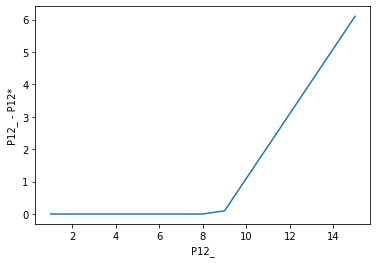

In [9]:
# DC OPF Solver w/ Line Constraints

PL = 20 # load
CQ = np.array([3, 2]) # cost; coefficients of quadratic terms
CL = np.array([1, 10]) # cost; coefficients of linear terms
F = np.arange(1,16) # line capacity

graph1 = []
graph2a = []
graph2b = []

# define the optimization problem
PG = cvx.Variable(2) # optimization variables: PG1 and PG2
P12 = cvx.Variable(1) # optimization variables: P12

objective = cvx.quad_form(PG, np.diag(CQ)) + PG * CL # objective function. compact form of 
                                                     # CQ(1)*PG(1)^2+CL(1)*PG(1) +CQ(2)*PG(2)^2+CL(2)*PG(2)

for f in F:
    constraints = [PG[0] == P12, PG[1] + P12 == PL, -f <= P12, P12 <= f]
    prob = cvx.Problem(cvx.Minimize(objective), constraints)
    result = prob.solve()

    graph1.append(f-P12.value)
    graph2a.append(constraints[0].dual_value)
    graph2b.append(constraints[1].dual_value)
    
plt.plot(F,graph1)
plt.ylabel("P12_ - P12*")
plt.xlabel("P12_")

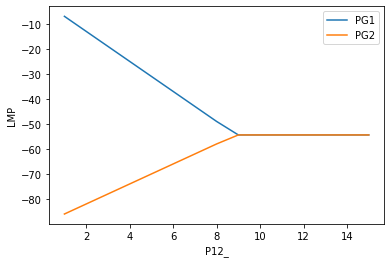

In [12]:
plt.plot(F,graph2a,F, graph2b)
plt.ylabel("LMP")
plt.xlabel("P12_")
plt.legend(["PG1","PG2"])

In [46]:
Ybus = csr_matrix([[2.2-21j,-1+10j,-1.2+11j,0,0],
                   [-1+10j,2.3-15.6j,0,-1.3+5.6j,0],
                   [-1.2+11j,0,1.35-20.8j,-1.15+9.8j,0],
                   [0,-1.3+5.6j,-1.15+9.8j,3.85-27j,-1.4+11.6j],
                   [0,0,0,-1.4+11.6j,1.4-11.6j]])

B = Ybus.imag
p = np.divide([0,163,-90,-100,-125],100) 
slack = 0

theta = pf_dc(B,p,slack)

print(theta)

[ 0.         -0.01900748  0.15546134  0.23812203  0.34588065]


In [47]:
np.multiply(B.dot(theta),100)

array([ 152.,  163.,  -90., -100., -125.])

In [48]:
P12 = 100 * B[0,1] * (theta[1] - theta[0])
P13 = 100 * B[0,2] * (theta[2] - theta[0])
P24 = 100 * B[1,3] * (theta[3] - theta[1])
P34 = 100 * B[2,3] * (theta[3] - theta[2])
P45 = 100 * B[3,4] * (theta[4] - theta[3])

PL = [P12, P13, P24, P34, P45]
PL

[-19.00747590005901,
 171.00747590005903,
 143.992524099941,
 81.00747590005909,
 125.00000000000006]

In [95]:
# SF

SF = 90 * (0.01 + 0.02j)
Ybus = csr_matrix([[2.2-21j,-1+10j,-1.2+11j,0,0,0],
                   [-1+10j,2.3-15.6j,0,-1.3+5.6j,0,0],
                   [-1.2+11j,0,1.35-20.8j,-1.15+9.8j,0,0],
                   [0,-1.3+5.6j,-1.15+9.8j,3.85-27j,-1.4+11.6j,0],
                   [0,0,0,-1.4+11.6j,(1.4-11.6j) + SF,-SF],
                   [0,0,0,0,-SF,SF]])

B = Ybus.imag
p = np.divide([152,163,-90,-100,-125,-80],100) 
slack = 0

theta = pf_dc(B,p,slack)

P12 = 100 * B[0,1] * (theta[1] - theta[0])
P13 = 100 * B[0,2] * (theta[2] - theta[0])
P24 = 100 * B[1,3] * (theta[3] - theta[1])
P34 = 100 * B[2,3] * (theta[3] - theta[2])
P45 = 100 * B[3,4] * (theta[4] - theta[3])
P56 = 100 * B[4,5] * (theta[5] - theta[4])

PL = [P12, P13, P24, P34, P45, P56]
PL

[13.729096989966576,
 218.2709030100335,
 176.7290969899666,
 128.2709030100335,
 205.00000000000006,
 80.0]

In [96]:
# SJ

SF = 120 * (0.01 + 0.02j)
Ybus = csr_matrix([[2.2-21j,-1+10j,-1.2+11j,0,0,0],
                   [-1+10j,2.3-15.6j,0,-1.3+5.6j,0,0],
                   [-1.2+11j,0,1.35-20.8j,-1.15+9.8j,0,0],
                   [0,-1.3+5.6j,-1.15+9.8j,(3.85-27j)+SF,-1.4+11.6j,-SF],
                   [0,0,0,-1.4+11.6j,(1.4-11.6j),0],
                   [0,0,0,-SF,0,SF]])

B = Ybus.imag
p = np.divide([152,163,-90,-100,-125,-80],100) 
slack = 0

theta = pf_dc(B,p,slack)

P12 = 100 * B[0,1] * (theta[1] - theta[0])
P13 = 100 * B[0,2] * (theta[2] - theta[0])
P24 = 100 * B[1,3] * (theta[3] - theta[1])
P34 = 100 * B[2,3] * (theta[3] - theta[2])
P45 = 100 * B[3,4] * (theta[4] - theta[3])
P46 = 100 * B[3,5] * (theta[5] - theta[3])

PL = [P12, P13, P24, P34, P45, P46]
PL

[13.729096989966564,
 218.27090301003352,
 176.7290969899666,
 128.27090301003346,
 125.00000000000009,
 80.00000000000003]

In [97]:
# Fresno

SF = 170 * (0.01 + 0.02j)
Ybus = csr_matrix([[2.2-21j,-1+10j,-1.2+11j,0,0,0],
                   [-1+10j,(2.3-15.6j)+SF,0,-1.3+5.6j,0,-SF],
                   [-1.2+11j,0,1.35-20.8j,-1.15+9.8j,0,0],
                   [0,-1.3+5.6j,-1.15+9.8j,(3.85-27j),-1.4+11.6j,0],
                   [0,0,0,-1.4+11.6j,(1.4-11.6j),0],
                   [0,-SF,0,0,0,SF]])

B = Ybus.imag
p = np.divide([152,163,-90,-100,-125,-80],100) 
slack = 0

theta = pf_dc(B,p,slack)

P12 = 100 * B[0,1] * (theta[1] - theta[0])
P13 = 100 * B[0,2] * (theta[2] - theta[0])
P24 = 100 * B[1,3] * (theta[3] - theta[1])
P34 = 100 * B[2,3] * (theta[3] - theta[2])
P45 = 100 * B[3,4] * (theta[4] - theta[3])
P26 = 100 * B[1,5] * (theta[5] - theta[1])

PL = [P12, P13, P24, P34, P45, P26]
PL
np.multiply(B.dot(theta),100)

array([ 232.,  163.,  -90., -100., -125.,  -80.])

In [93]:
# Fresno

SF = 170 * (0.01 + 0.02j)
Ybus = csr_matrix([[2.2-21j+1.2-6j,-1+10j,-1.2+11j,0,0,0,-1.2+6j],
                   [-1+10j,(2.3-15.6j)+SF,0,-1.3+5.6j,0,-SF,0],
                   [-1.2+11j,0,1.35-20.8j,-1.15+9.8j,0,0,0],
                   [0,-1.3+5.6j,-1.15+9.8j,(3.85-27j+1.03-8.3j),-1.4+11.6j,0,-1.03+8.3j],
                   [0,0,0,-1.4+11.6j,(1.4-11.6j),0,0],
                   [0,-SF,0,0,0,SF,0],
                   [-1.2+6j,0,0,-1.03+8.3j,0,0,2.23-14.3j]])

B = Ybus.imag
p = np.divide([232 ,163,-90,-100,-125,-80,94],100) 
slack = 0

theta = pf_dc(B,p,slack)

np.multiply(B.dot(theta),100)

array([ 138.,  163.,  -90., -100., -125.,  -80.,   94.])

In [94]:
P12 = 100 * B[0,1] * (theta[1] - theta[0])
P13 = 100 * B[0,2] * (theta[2] - theta[0])
P24 = 100 * B[1,3] * (theta[3] - theta[1])
P34 = 100 * B[2,3] * (theta[3] - theta[2])
P45 = 100 * B[3,4] * (theta[4] - theta[3])
P26 = 100 * B[1,5] * (theta[5] - theta[1])
P17 = 100 * B[0,6] * (theta[6] - theta[0])
P47 = 100 * B[3,6] * (theta[6] - theta[3])

PL = [P12, P13, P24, P34, P45, P26, P17, P47]
PL


[0.41407948906939385,
 125.00888495465163,
 83.41407948906938,
 35.00888495465162,
 125.00000000000009,
 79.99999999999999,
 12.577035556279032,
 -106.57703555627899]

In [6]:
## don't know how to make this work

file = pd.read_csv('C:/Users/samanyl/Box/Work Files/Working Files/hrc_loads.csv')
hrc_2011 = file['HRC 2011']
P = file['$/kw-10min']
GUL = 2500
GLL = 2000
eff = 1.41
T = len(hrc_2011)
LL = np.sum(hrc_2011)

PG = cvx.Variable(T) # define the variable with its dimension
objective = cvx.norm(P*(eff*PG), p = 2) # define the objective function
constraints = [PG <= GUL, x >= 0, np.sum(PG) == LL]
prob = cvx.Problem(cvx.Minimize(objective), constraints)
result = prob.solve()

print(result)  # optimal value of objective
print(objective.value)  # optimal value of objective
print(PG.value)

C:\Users\samanyl\AppData\Local\Continuum\anaconda3\lib\site-packages\cvxpy\expressions\expression.py:516: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.

  warnings.warn(__STAR_MATMUL_WARNING__, UserWarning)


ValueError: setting an array element with a sequence.